In [16]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from brian2 import *
from brian2.units.allunits import henry
import tpam_tool as tp

from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

def crvec(N, D=1):
    rphase = 2*np.pi * np.random.rand(D, N)
    return np.cos(rphase) + 1.0j * np.sin(rphase)

def phase2spikes(cv, freq=5.0):
    st = np.angle(cv) / (2*pi*freq)
    return st

In [17]:
# Neuron parameters
C_ex = 0.5 * nF # Capacitance of action-potential compartment
C_in = 0.5 * nF # Capacitance of inhibitory cells

g_l =  4.0 * nS # leak conductance
E_l = -65.0 * mV # Resting potential

V_t = 30.0 * mV # Threshold
V_r = -65.0 * mV # Reset

eqs_1 = Equations('''
I = I_ext + I_rec + I_inh + I_c : amp
dV/dt= ((0.04/(mV*ms)*V**2 + 5/(ms)*V + 140*(mV/ms) - U/ms + (not_refractory)*80*(I)/nA*mV/ms)) : volt
dU/dt = a*(b*V - U) : volt
I_ext : amp
I_rec : amp
I_inh : amp
I_c : amp
a: 1/second
b: 1
d: volt
''')
eqs_1_in = Equations('''
I = I_ext + I_rec + I_inh + I_c : amp
dV/dt= ((0.04/(mV*ms)*V**2 + 5/(ms)*V + 140*(mV/ms) - U/ms + (not_refractory)*80*(I)/nA*mV/ms)) : volt
dU/dt = a*(b*V - U) : volt
I_ext : amp
I_rec : amp
I_inh : amp
I_c : amp
a: 1/second
b: 1
d: volt
''')

s_delay = 0
s_c_freq = (2*np.pi* (5.0)) / second

s_delay_pre = '''
mag : 1
I_ext_post = sx * nA : amp (summed)
dsx/dt = -s_c_freq * sx : 1 (clock-driven)
'''
s_delay_inh = '''
mag : 1
I_inh_post = sx * nA : amp (summed)
dsx/dt = -0.25*s_c_freq * sx : 1 (clock-driven)
'''
s_delay_rec = '''
mag : 1
I_rec_post = sx * nA : amp (summed)
dsx/dt = -s_c_freq * sx : 1 (clock-driven)
'''

s_delay_on_pre = '''
sx += mag
'''

In [18]:
N_vec = 500
N_inh_ff = 5
N_out = 200

In [19]:
Ks = int(0.05 * N_vec)

# pvecs = crvec(N_vec, N_out).T
# for d in range(N_out):
#     ip = np.random.choice(N_vec, size=(N_vec-Ks), replace=False)
#     pvecs[ip, d] = 0

pvecs = tp.load_complex_matrix(f'samples/pvecs_izh_{N_out}.npz')
# pmat = np.dot(pvecs, np.conj(pvecs.T)) / Ks
# np.fill_diagonal(pmat, 0)
pmat = tp.stdp_learn(pvecs, epochs=1, tau_p=0.8, tau_n=0.8, Ap = 0.62, An=0.62) / Ks

Matrix loaded from samples/pvecs_izh_200.npz
0th training epoch
0.0%th column processed
10.0%th column processed
20.0%th column processed
30.0%th column processed
40.0%th column processed
50.0%th column processed
60.0%th column processed
70.0%th column processed
80.0%th column processed
90.0%th column processed


In [20]:
target_idx = 86
init_vector = pvecs[:, target_idx].copy()
#init_vector += pvecs[:, 7] + pvecs[:, 22]
init_vector[200:] = 0

In [21]:
stt = phase2spikes(init_vector)*second  +0.11*second
spike_indices = np.arange(stt.shape[0])

In [22]:
keep_idx = np.abs(init_vector) > 0.5
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

In [23]:
nreps = 1
spike_times = np.tile(stt, (nreps))
spike_indices = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times[(i*N_vec):((i+1)*N_vec)] = spike_times[:N_vec] + i * 200*ms

In [24]:
phase_shift =  np.arctan(g_l/(s_c_freq *  C_ex))
rc_delay = phase_shift/s_c_freq

print('RC delay:', rc_delay)

RC delay: 7.93700478 ms


In [25]:
G_pre = SpikeGeneratorGroup(N_vec, spike_indices, spike_times)

G_post = NeuronGroup(N_vec, model=eqs_1, threshold='V>V_t', reset='V=V_r;U+=d', refractory=150*ms, method='euler')
G_inh_ff = NeuronGroup(N_inh_ff, model=eqs_1_in, threshold='V>V_t', reset='V=V_r;U+=d', refractory=0*ms, method='euler')

G_post.V = E_l * ones(N_vec) + 0*mV * np.random.randn(N_vec)
G_post.I_c = 1.0 * pA + 1.0*pA *np.random.randn(N_vec)
G_inh_ff.V = E_l * ones(N_inh_ff) + 0*mV * np.random.randn(N_inh_ff)
G_inh_ff.I_c = 1.0 * pA + 1.0*pA *np.random.randn(N_inh_ff)

G_post.a = 0.02/ms * ones(N_vec)
G_post.b = 0.2 * ones(N_vec)
G_post.d = 1*mV * ones(N_vec)
G_post.U = -13*mV * ones(N_vec)
G_inh_ff.a = 0.02/ms * ones(N_inh_ff)
G_inh_ff.b = 0.2 * ones(N_inh_ff)
G_inh_ff.d = 1*mV * ones(N_inh_ff)
G_inh_ff.U = -13*mV * ones(N_inh_ff)

S_pre_post = Synapses(G_pre, G_post, s_delay_pre, on_pre=s_delay_on_pre, method='euler')
S_pre_inh_ff = Synapses(G_pre, G_inh_ff, s_delay_pre, on_pre=s_delay_on_pre, method='euler')

S_recurrent = Synapses(G_post, G_post, s_delay_rec, on_pre=s_delay_on_pre, method='euler')
#S_post_inh_ff = Synapses(G_post, G_inh_ff, s_delay_inh, on_pre=s_delay_on_pre, method='euler')
S_post_inh_ff = Synapses(G_post, G_inh_ff, s_delay_rec, on_pre=s_delay_on_pre, method='euler')

S_inh_ff_post = Synapses(G_inh_ff, G_post, s_delay_inh, on_pre=s_delay_on_pre, method='euler')


S_pre_post.connect(j='i')
S_pre_post.mag = 0.3
S_pre_post.delay = 30.0*ms

S_pre_inh_ff.connect()
S_pre_inh_ff.mag = 0.5/Ks
S_pre_inh_ff.delay = 0.0*ms


syn_thresh = 0.1 / (2*N_vec) ** 0.5
synidxs = np.where(np.abs(pmat.T) > syn_thresh)
S_recurrent.connect(i=synidxs[0], j=synidxs[1])

syn_idxs_f = np.where(np.abs(pmat.T).flatten() > syn_thresh)[0]
syn_abs = np.abs(pmat.T).flatten()
syn_phase = np.angle(pmat.T).flatten()
S_recurrent.mag = 1.5 * syn_abs[syn_idxs_f]
S_recurrent.delay = syn_phase[syn_idxs_f] / s_c_freq + 2*np.pi/s_c_freq - 1.5*rc_delay


S_post_inh_ff.connect()
S_post_inh_ff.mag = 0.6/Ks
S_post_inh_ff.delay = 2.0*ms


S_inh_ff_post.connect()
S_inh_ff_post.mag = -0.04 / N_inh_ff
S_inh_ff_post.delay = 2.0*ms


SpM_post = SpikeMonitor(G_post)
SpM_inh_ff = SpikeMonitor(G_inh_ff)

StM_post = StateMonitor(G_post, True, record=True)
StM_inh_ff = StateMonitor(G_inh_ff, True, record=True)

WARNING    'i' is an internal variable of group 'synapses_5', but also exists in the run namespace with the value 0. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


In [26]:
complex_net = Network()
complex_net.add(G_pre)
complex_net.add(G_post)
complex_net.add(G_inh_ff)

complex_net.add(S_pre_post)
complex_net.add(S_pre_inh_ff)

complex_net.add(S_inh_ff_post)

complex_net.add(S_recurrent)
complex_net.add(S_post_inh_ff)

complex_net.add(SpM_post)
complex_net.add(SpM_inh_ff)
complex_net.add(StM_post)
complex_net.add(StM_inh_ff)

complex_net.store('init')

In [27]:
run_time = 5.0 * second
complex_net.restore('init')
tst = time.time()
complex_net.run(run_time)
print("elapsed", time.time() - tst)

elapsed 181.34243178367615


189.5 ms


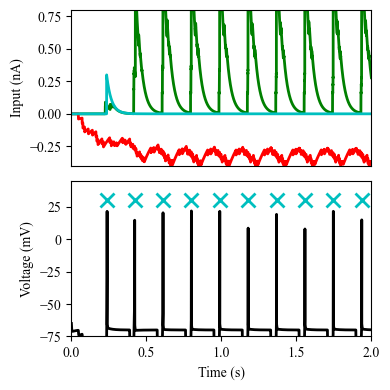

In [28]:
figure(figsize=(4,4))

N_ex = spike_indices[2]

subplot(2,1,1)
plot(StM_post.t / second, StM_post.I_rec[N_ex,:]/nA, 'g', lw=2)
plot(StM_post.t / second, StM_post.I_inh[N_ex,:]/nA, 'r', lw=2)
plot(StM_post.t / second, StM_post.I_ext[N_ex,:]/nA, 'c', lw=2)
xticks([])
xlim([0, 2])
ylim([-0.4, 0.8])
ylabel('Input (nA)')

subplot(2,1,2)
plot(StM_post.t/ second, StM_post.V[N_ex,:] / mV, 'k', lw=2);
spike_trains_post = SpM_post.spike_trains()
plot(spike_trains_post[N_ex]/second, V_t / mV * ones(len(spike_trains_post[N_ex])), 'cx', lw=2, mew=2, ms=10)

print(np.median(np.diff(spike_trains_post[N_ex])))

xlim([0,2.0])
ylim([-75, 45])
xlabel('Time (s)')
ylabel('Voltage (mV)')

plt.tight_layout()


25 == 25


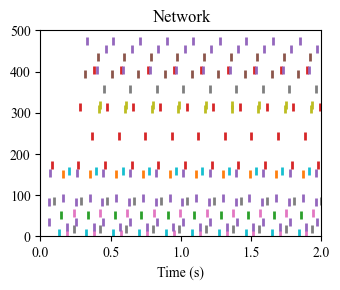

In [29]:
figure(figsize=(3.5,3))

c=0
for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)
    if len(spike_trains_post[i])>2:
        c+=1
        
print(c, '==', Ks)

xlim([0,2])
ylim([0, N_vec])

xlabel('Time (s)')
title('Network')

plt.tight_layout()


25 == 25


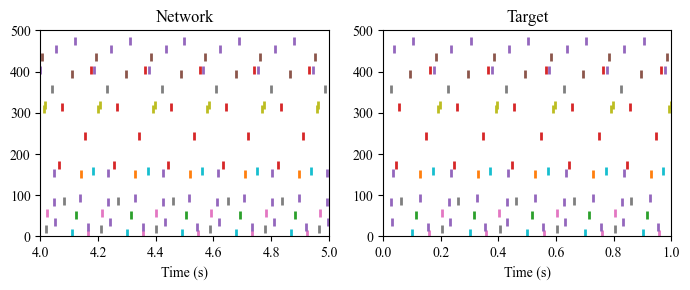

In [30]:
figure(figsize=(7,3))

subplot(121)
c=0
for i in range(N_vec):
    plot(spike_trains_post[i], i * ones(len(spike_trains_post[i])), '|', mew=2)
    if len(spike_trains_post[i])>2:
        c+=1
        
print(c, '==', Ks)

xlim([4,5])
ylim([0, N_vec])

xlabel('Time (s)')
title('Network')


target_vector = pvecs[:, target_idx].copy()

stt = phase2spikes(target_vector)*second  +0.11*second
spike_indices = np.arange(stt.shape[0])

keep_idx = np.abs(target_vector) > 0.5
stt = stt[keep_idx]
spike_indices = spike_indices[keep_idx]

nreps = 10
spike_times_target = np.tile(stt, (nreps))
spike_indices_target = np.tile(spike_indices, (nreps))

for i in range(nreps):
    spike_times_target[(np.arange(len(stt)) + i * len(stt))] = spike_times_target[:len(stt)] + i * 200*ms

    
subplot(122)
for i in range(N_vec):
    sp_times = spike_times_target[spike_indices_target==i]
    plot(sp_times, i*np.ones(sp_times.shape) , '|', mew=2)

xlabel('Time (s)')
xlim([0, 1])
ylim([0, N_vec])
title('Target')

plt.tight_layout()
